# PRODUCTS

**A. CLEAN UP AND PREPARE PRODUCT DATA**

A.1 Load and plot

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt

import os

# pip install fuzzywuzzy
from fuzzywuzzy import fuzz

from operator import itemgetter

import re

import seaborn as sns

#Website object lists : https://7esl.com/tools-and-equipment/#Technological_Gadgets

In [2]:
os.getcwd()

'/Users/lou/Documents/Travail/master 2/ADA/epfl-ada-2019-project-bubble582/code'

In [3]:
#load the data
hh_demographic = pd.read_csv('../data/dunnhumby_complete_csv/hh_demographic.csv', sep = ',')

transaction_data = pd.read_csv('../data/dunnhumby_complete_csv/transaction_data.csv', sep = ',')

product = pd.read_csv('../data/dunnhumby_complete_csv/product.csv', sep = ',')

FoodLabels = pd.read_csv('../data/dunnhumby_complete_csv/FoodLabelsV3.csv', sep = ',')

# This is a list a created. It is a small file, I m going to push it in data in order you can have it at home
ObjectLabels = pd.read_csv('../data/dunnhumby_complete_csv/GroceryLists.csv', sep = ',')
ObjectLabels.columns = ['ITEM','LABEL']

In [4]:
product.head(4)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ


First we get interested by the different departments in the commercial center. We reorder the departments and plot the number of different products we can find per department. 

In [5]:
# REORDERING PART
ordered_manufacturer= product.MANUFACTURER.astype(int).sort_values()
ordered_manufacturer= ordered_manufacturer.unique()

product['MANUFACTURER'] = pd.Categorical(product['MANUFACTURER'],
                      ordered = True,
                      categories = ordered_manufacturer)

print ('The order of the manufacturer categories is :', ordered_manufacturer)

# remove empty products
product= product.drop(product[product['DEPARTMENT']== ' '].index)

The order of the manufacturer categories is : [   1    2    3 ... 6475 6476 6477]


In [6]:
ordered_department= ['GROCERY','FROZEN GROCERY','GRO BAKERY','PASTRY',
        'SEAFOOD','SEAFOOD-PCKGD','MEAT', 'MEAT-PCKGD','MEAT-WHSE','PORK','SPIRITS','NUTRITION',
       'PRODUCE','CHEF SHOPPE','RESTAURANT','SALAD BAR','DELI', 'DAIRY DELI','DELI/SNACK BAR',
    'DRUG GM','COSMETICS','PHARMACY SUPPLY','GARDEN CENTER','FLORAL', 'TRAVEL & LEISUR', 
    'POSTAL CENTER', 'PHOTO', 'VIDEO','VIDEO RENTAL','TOYS','HOUSEWARES', 
    'KIOSK-GAS', 'ELECT &PLUMBING','AUTOMOTIVE','GM MERCH EXP','COUP/STR & MFG', 
     'CHARITABLE CONT', 'RX','PROD-WHS SALES', 'HBC','CNTRL/STORE SUP','MISC. TRANS.', 'MISC SALES TRAN',' ']

product['DEPARTMENT'] = pd.Categorical(product['DEPARTMENT'],
                      ordered = True,
                      categories = ordered_department)

print ('The order of the department categories is :', ordered_department)

The order of the department categories is : ['GROCERY', 'FROZEN GROCERY', 'GRO BAKERY', 'PASTRY', 'SEAFOOD', 'SEAFOOD-PCKGD', 'MEAT', 'MEAT-PCKGD', 'MEAT-WHSE', 'PORK', 'SPIRITS', 'NUTRITION', 'PRODUCE', 'CHEF SHOPPE', 'RESTAURANT', 'SALAD BAR', 'DELI', 'DAIRY DELI', 'DELI/SNACK BAR', 'DRUG GM', 'COSMETICS', 'PHARMACY SUPPLY', 'GARDEN CENTER', 'FLORAL', 'TRAVEL & LEISUR', 'POSTAL CENTER', 'PHOTO', 'VIDEO', 'VIDEO RENTAL', 'TOYS', 'HOUSEWARES', 'KIOSK-GAS', 'ELECT &PLUMBING', 'AUTOMOTIVE', 'GM MERCH EXP', 'COUP/STR & MFG', 'CHARITABLE CONT', 'RX', 'PROD-WHS SALES', 'HBC', 'CNTRL/STORE SUP', 'MISC. TRANS.', 'MISC SALES TRAN', ' ']


In [7]:
# We drop weird department data. These data are either incomprehensible or appear to be inaccurate
product= product.drop(product[product['DEPARTMENT']== ' '].index)
product= product.drop(product[product['DEPARTMENT']== 'PHOTO'].index)
product= product.drop(product[product['DEPARTMENT']== 'VIDEO'].index)
product= product.drop(product[product['DEPARTMENT']== 'MISC. TRANS.'].index)
product= product.drop(product[product['DEPARTMENT']== 'MISC SALES TRAN'].index)
product= product.drop(product[product['DEPARTMENT']== 'MEAT-WHSE'].index)
# this department in the coupon store. Our study does not take into account the coupons
product= product.drop(product[product['DEPARTMENT']== 'COUP/STR & MFG'].index)

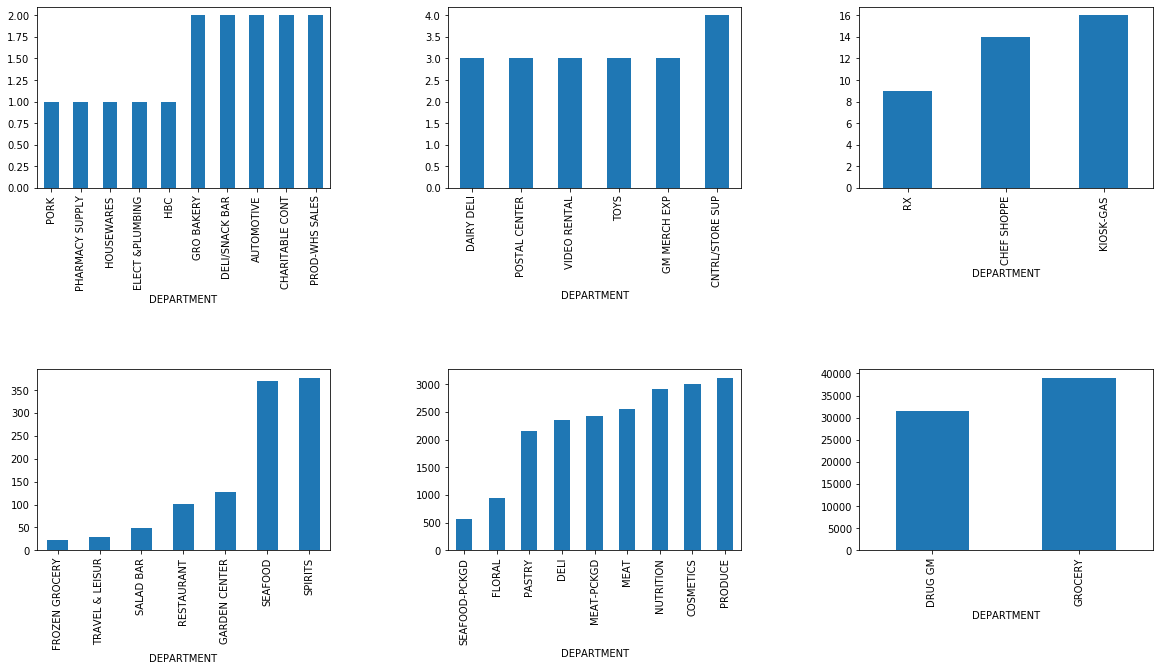

In [8]:
department= product.groupby(['DEPARTMENT']).count()

#PLOT THE NUMBER OF DIFFERENT PRODUCTS PER DEPARTMENT

fig = plt.figure(figsize=(20,10))

# Divide the figure into a 2x1 grid, and give me the first section
ax1 = fig.add_subplot(231)

# Divide the figure into a 2x1 grid, and give me the second section
ax2 = fig.add_subplot(232)

ax3 = fig.add_subplot(233)

ax4 = fig.add_subplot(234)

ax5 = fig.add_subplot(235)

ax6 = fig.add_subplot(236)

department[(department.BRAND>0) & (department.BRAND<=2)].BRAND.sort_values().plot.bar(ax=ax1)
department[(department.BRAND>2) & (department.BRAND<=5)].BRAND.sort_values().plot.bar(ax=ax2)
department[(department.BRAND>5) & (department.BRAND<=20)].BRAND.sort_values().plot.bar(ax=ax3)
department[(department.BRAND>20) & (department.BRAND<=500)].BRAND.sort_values().plot.bar(ax=ax4)
department[(department.BRAND>500) & (department.BRAND<=4000)].BRAND.sort_values().plot.bar(ax=ax5)
department[department.BRAND>4000].BRAND.sort_values().plot.bar(ax=ax6)

fig.subplots_adjust(hspace=1)
fig.subplots_adjust(wspace=0.4)


As we can see in the previous barplots, the departments with the highest number of referenced products in this study are the grocery with almost 40000 products, and the drug GM (which is probably a drug store) with more than 30000 products. We are going to focus on these 2 mains stores in a first time.

**A. CLEANING UP PRODUCT DATAFRAME**

**B. GROCERY DATA PREPROCESSING**

In this part we are interested to clean up and categorize the different products from the grocery store. We want to explain what purpose they serve (food, households, & hygien products, pet products etc.). We create a special Grocery dataframe for this purpose.

In [9]:
#we extract the grocery product data which is the main supermarket in the commercial center
Grocery= pd.DataFrame(product[product['DEPARTMENT'] == 'GROCERY'])
Grocery.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
5,26426,69,GROCERY,Private,SPICES & EXTRACTS,SPICES & SEASONINGS,2.5 OZ
6,26540,69,GROCERY,Private,COOKIES/CONES,TRAY PACK/CHOC CHIP COOKIES,16 OZ


The only product descriptions provided by the Grocery data are few words descriptions found in COMMODITY_DESC and SUB_COMMODITY_DESC columns. These descriptions are not standardized, no categories arise from them. 

In a first time, we want to categorize the words in the descriptions using different labels (produce, households, technology ...). To do so we create a function called "LabelizeProduct". This function first recognizes the different words or words sequences in the description. These words or words sequences are associated with a certain label in a list of shopping items ("GroceryList.csv"). In a second time, based on the fuzzywuzzy librairy, the "LabelizeProduct" gives a score with comparing the description and the shopping item corresponding to words sequence identified. Finally, the functions keep the label for which the score is the highest. 

In [10]:
# This function is able to categorize the products given in data with looking at a labelled list of words. 
#This labelled list of words is a lexique of grocery and shopping words. The threshold is the smallest 
#fuzzywuzzy score accepted to declare a match. (fuzzywuzzy gives a score of string matching over 100 )

# data is the  dataset to categorize, dataCol is the column of the dataset to categorize, 
#threshold is the minimal fuzzywuzzy score accepted. If score lower than threshold, 
#the item is categorized as 'not found'. 
#wordList is the list of words associated with a Label. wordList : ['ITEM','LABEL']
def LabelizeProduct(data, dataCol, threshold, wordList) :
    
    Out = pd.DataFrame(index = data.index, columns = ['Item','Ratio','Label'])
    
    #count to show progression when running (can take few minutes)
    loopCounter = 0
    # iterate on the index of the dataset to categorize
    for indexCOM in data.index :
        
        if (loopCounter%100 == 0): 
            print(loopCounter)
        
        # the item to categorize in the dataCol
        item = dataCol.loc[indexCOM]
        #a vector to keep all the matches within the grocerylist.csv
        match = []
        #set the output table
        Out.Item[indexCOM] = item
        Out.Label[indexCOM] = 'not found'
        Out.Ratio[indexCOM]= 0
        
        #iterate on the wordList's items (belonging to a certain label)
        for index,label in enumerate(wordList.LABEL) :
            
            # get all the separated words in the wordList item
            line = re.split(' |&|/',wordList.ITEM[index])
            
            #iterate on the separated words in the wordList item
            for word in line:
                #manage case (everything in lowercase)
                lword= word.lower()
                litem = item.lower()

                # if we find the word from wordList item, in the description of the data:
                # we calculate the fuzzywuzzy ratio(%) and we append the match in the match vector
                if litem.find(lword)!= -1:
                    ratio = fuzz.token_sort_ratio(str.lower(item), str.lower(lword))
                    match.append((indexCOM,line,ratio,label))
                    
        # if the match vector is not empty, then we attribute the label corresponding to the max ratio 
        #to the description            
        if (match) and (max(match,key=itemgetter(2))[2]>= threshold)  :
            Out.Label[indexCOM] = max(match,key=itemgetter(2))[3]
            Out.Ratio[indexCOM]= max(match,key=itemgetter(2))[2]
            
        loopCounter += 1
            
    return Out

We use our new function "LabelizeProduct" to find the main categories in the Grocery department.

In [11]:
LabelledSUB = LabelizeProduct(Grocery, Grocery.SUB_COMMODITY_DESC, 0, ObjectLabels)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [12]:
Labelled = LabelizeProduct(Grocery, Grocery.COMMODITY_DESC, 0, ObjectLabels) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [13]:
Labelled['RatioSUB']= LabelledSUB.Ratio
Labelled['LabelSUB']= LabelledSUB.Label

We create a second function "putLabel" that sets the label with the highest fuzzy ratio in between the 2 columns that were categorized (here COMMODITY_DESC and SUB_COMMODITY_DESC) in the main data set (here Grocery). 

In [15]:
Grocery['Label'] = 'none'

# this is the function that put the Labels in the main data Table. It compares the labels and fuzzy scores for 
# COMMODITY and SUB_COMMODITY labelled data and chooses the best one. 
def putLabel(LabelledData, data) :
    for line in LabelledData.index : 

        maxRatio = max(LabelledData.Ratio.loc[line],LabelledData.RatioSUB.loc[line])
        if LabelledData.Ratio.loc[line] == maxRatio :
            data['Label'].loc[line] = LabelledData.Label.loc[line]
        elif LabelledData.RatioSUB.loc[line] == maxRatio :
            data['Label'].loc[line] = LabelledData.LabelSUB.loc[line]
    return 0

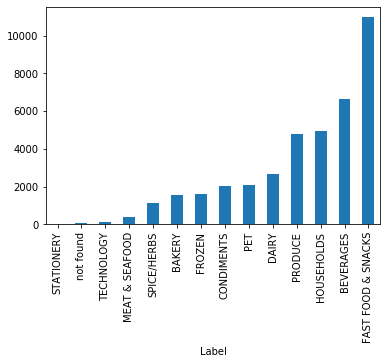

In [17]:
putLabel(Labelled, Grocery)

LabelCount= Grocery.groupby('Label').count()

LabelCount.BRAND.sort_values().plot.bar()

In [18]:
Grocery.to_csv('Grocery.csv')

As we can see in the following table the Grocery store product have been Labelled. Error of classification are possible (even if low rate --> to estimate, HOW ?). Indeed the "LabelizeProduct" recognizes words that are provided in the "wordList" to the function. The accuracy of the classification relies on the thoroughness of this word list. Moreover if the word list does not contain enough words, the quantity of 'not found' increases drastically.

In [28]:
Grocery.groupby('Label').count()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
Label,,,,,,,
BAKERY,1552,1552,1552,1552,1552,1552,1552
BEVERAGES,6671,6671,6671,6671,6671,6671,6671
CONDIMENTS,2037,2037,2037,2037,2037,2037,2037
DAIRY,2656,2656,2656,2656,2656,2656,2656
FAST FOOD & SNACKS,10976,10976,10976,10976,10976,10976,10976
FROZEN,1595,1595,1595,1595,1595,1595,1595
HOUSEHOLDS,4929,4929,4929,4929,4929,4929,4929
MEAT & SEAFOOD,374,374,374,374,374,374,374
PET,2064,2064,2064,2064,2064,2064,2064


**C. LET'S DO IT AGAIN WITH DRUG GM**

In [21]:
#we extract the drug gm product data which is the second main store in the commercial center
DrugGM= pd.DataFrame(product[product['DEPARTMENT'] == 'DRUG GM'])
DrugGM.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
7,26601,69,DRUG GM,Private,VITAMINS,VITAMIN - MINERALS,300CT(1)
11,26889,32,DRUG GM,National,MAGAZINE,TV/MOVIE-MAGAZINE,
20,27334,69,DRUG GM,Private,DIETARY AID PRODUCTS,DIET CNTRL LIQS NUTRITIONAL,
108,29574,69,DRUG GM,Private,STATIONERY & SCHOOL SUPPLIES,SCHOOL SUPPLIES,1 CT
110,29618,69,DRUG GM,Private,COLD AND FLU,COLD AND FLU - PSE,10 OZ


In [22]:
LabelledDGM = LabelizeProduct(DrugGM, DrugGM.COMMODITY_DESC, 0,ObjectLabels) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [23]:
LabelledSUBDGM = LabelizeProduct(DrugGM, DrugGM.SUB_COMMODITY_DESC, 0,ObjectLabels) 

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [24]:
LabelledDGM['RatioSUB']= LabelledSUBDGM.Ratio
LabelledDGM['LabelSUB']= LabelledSUBDGM.Label
DrugGM['Label'] = 'none'
putLabel(LabelledDGM, DrugGM)

0

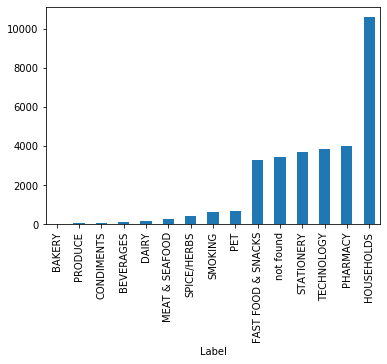

In [25]:
LabelDGMCount= DrugGM.groupby('Label').count()

LabelDGMCount.BRAND.sort_values().plot.bar()

In [29]:
DrugGM.groupby('Label').count()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
Label,,,,,,,
BAKERY,37,37,37,37,37,37,37
BEVERAGES,123,123,123,123,123,123,123
CONDIMENTS,77,77,77,77,77,77,77
DAIRY,189,189,189,189,189,189,189
FAST FOOD & SNACKS,3312,3312,3312,3312,3312,3312,3312
HOUSEHOLDS,10598,10598,10598,10598,10598,10598,10598
MEAT & SEAFOOD,297,297,297,297,297,297,297
PET,664,664,664,664,664,664,664
PHARMACY,4033,4033,4033,4033,4033,4033,4033


**D. ALL THE OTHER SHOPS: DELI, PRODUCE, NUTRITION, COSMETICS etc.**

Since all these other shops are specialized the labels are easy to infer. Indeed it corresponds to the shop specialization. We also put the Label computed before in the main dataset product. 

In [30]:
product['LABEL'] = 'none'
MEAT = product[product['DEPARTMENT'] == 'MEAT']
MEAT_PCKGD = product[product['DEPARTMENT'] == 'MEAT-PCKGD']
SEAFOOD = product[product['DEPARTMENT'] == 'SEAFOOD']
SEAFOOD_PCKGD = product[product['DEPARTMENT'] == 'SEAFOOD-PCKGD']
FROZEN_GROCERY = product[product['DEPARTMENT'] == 'FROZEN GROCERY']

MEAT.loc['LABEL'] = 'MEAT & SEAFOOD'
MEAT_PCKGD.loc['LABEL'] = 'MEAT & SEAFOOD'
SEAFOOD.loc['LABEL'] = 'MEAT & SEAFOOD'
SEAFOOD_PCKGD.loc['LABEL'] = 'MEAT & SEAFOOD'
FROZEN_GROCERY.loc['LABEL'] = 'FROZEN'

In [31]:
# we standardize some labels for the seek of the vizualization. Uncomment the next line the first time
# I had trouble with the label setting in the main data set product. This is a shitty implementation but working. 
#I have to figure it out

product.DEPARTMENT.loc[product['DEPARTMENT']== 'DAIRY DELI'] = 'DELI'
product.LABEL.loc[product['DEPARTMENT']== 'PHARMACY SUPPLY'] = 'PHARMACY'
product.LABEL.loc[product['DEPARTMENT']== 'PORK'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'RX'] = 'PHARMACY'
product.LABEL.loc[product['DEPARTMENT']== 'HOUSEWARES'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'ELECT &PLUMBING'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'HBC'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'DELI/SNACK BAR'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'CHARITABLE CONT'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'PROD-WHS SALES'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'GM MERCH EXP'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'CNTRL/STORE SUP'] = 'not found'
product.LABEL.loc[product['DEPARTMENT']== 'GRO BAKERY'] = 'BAKERY'
product.LABEL.loc[product['DEPARTMENT']== 'PASTRY'] = 'BAKERY'
product.LABEL.loc[product['DEPARTMENT']== 'AUTOMOTIVE'] = 'STATIONERY'
product.LABEL.loc[product['DEPARTMENT']== 'POSTAL CENTER'] = 'FAST FOOD & SNACKS'
product.LABEL.loc[product['DEPARTMENT']== 'CHEF SHOPPE'] = 'FAST FOOD & SNACKS'
product.LABEL.loc[product['DEPARTMENT']== 'TRAVEL & LEISUR'] = 'PRODUCE'
product.LABEL.loc[product['DEPARTMENT']== 'SALAD BAR'] = 'RESTAURANT'
product.LABEL.loc[product['DEPARTMENT']== 'GARDEN CENTER'] = 'FLORAL'
product.LABEL.loc[product['DEPARTMENT']== 'FLORAL'] = 'FLORAL'
product.LABEL.loc[product['DEPARTMENT']== 'VIDEO RENTAL'] = 'VIDEO RENTAL'
product.LABEL.loc[product['DEPARTMENT']== 'KIOSK-GAS'] = 'GASOLINE'
product.LABEL.loc[product['DEPARTMENT']== 'TOYS'] = 'TOYS'
product.LABEL.loc[product['DEPARTMENT']== 'NUTRITION'] = 'NUTRITION'
product.LABEL.loc[product['DEPARTMENT']== 'COSMETICS'] = 'COSMETICS'
product.LABEL.loc[product['DEPARTMENT']== 'PRODUCE'] = 'PRODUCE'
product.LABEL.loc[product['DEPARTMENT']== 'MEAT'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'MEAT-PCKGD'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'SEAFOOD'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'SEAFOOD-PCKGD'] = 'MEAT & SEAFOOD'
product.LABEL.loc[product['DEPARTMENT']== 'FROZEN GROCERY'] = 'FROZEN'
product.LABEL.loc[product['DEPARTMENT']== 'SPIRITS'] = 'SPIRITS'
product.LABEL.loc[product['DEPARTMENT']== 'RESTAURANT'] = 'RESTAURANT'
product.LABEL.loc[product['DEPARTMENT'] == 'GROCERY'] = Grocery.Label
product.LABEL.loc[product['DEPARTMENT'] == 'DRUG GM'] = DrugGM.Label

product.LABEL.unique()



array(['FROZEN', 'BAKERY', 'PRODUCE', 'FAST FOOD & SNACKS', 'SPICE/HERBS',
       'PHARMACY', 'STATIONERY', 'HOUSEHOLDS', 'DAIRY', 'BEVERAGES',
       'CONDIMENTS', 'MEAT & SEAFOOD', 'NUTRITION', 'not found', 'none',
       'COSMETICS', 'PET', 'SMOKING', 'TECHNOLOGY', 'FLORAL',
       'RESTAURANT', 'GASOLINE', 'SPIRITS', 'TOYS', 'VIDEO RENTAL'],
      dtype=object)

The shop DELI needs also to be categorized.

In [32]:
# categorize the data in DELI
DELI = product[product['DEPARTMENT'] == 'DELI']
LabelledDELI = LabelizeProduct(DELI, DELI.COMMODITY_DESC, 0,ObjectLabels)
LabelledSUBDELI = LabelizeProduct(DELI, DELI.SUB_COMMODITY_DESC, 0,ObjectLabels)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [34]:
#add DELI labels in the product dataframe
LabelledDELI['RatioSUB']= LabelledSUBDELI.Ratio
LabelledDELI['LabelSUB']= LabelledSUBDELI.Label
DELI['Label'] = 'none'
putLabel(LabelledDELI, DELI)
DELI.groupby('Label').count()

/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/lou/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://p

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,LABEL
Label,,,,,,,,
BEVERAGES,36,36,36,36,36,36,36,36
CONDIMENTS,42,42,42,42,42,42,42,42
DAIRY,746,746,746,746,746,746,746,746
FAST FOOD & SNACKS,632,632,632,632,632,632,632,632
HOUSEHOLDS,44,44,44,44,44,44,44,44
MEAT & SEAFOOD,478,478,478,478,478,478,478,478
PRODUCE,359,359,359,359,359,359,359,359
not found,20,20,20,20,20,20,20,20


In [35]:
product.LABEL.loc[product['DEPARTMENT'] == 'DELI'] = DELI.Label

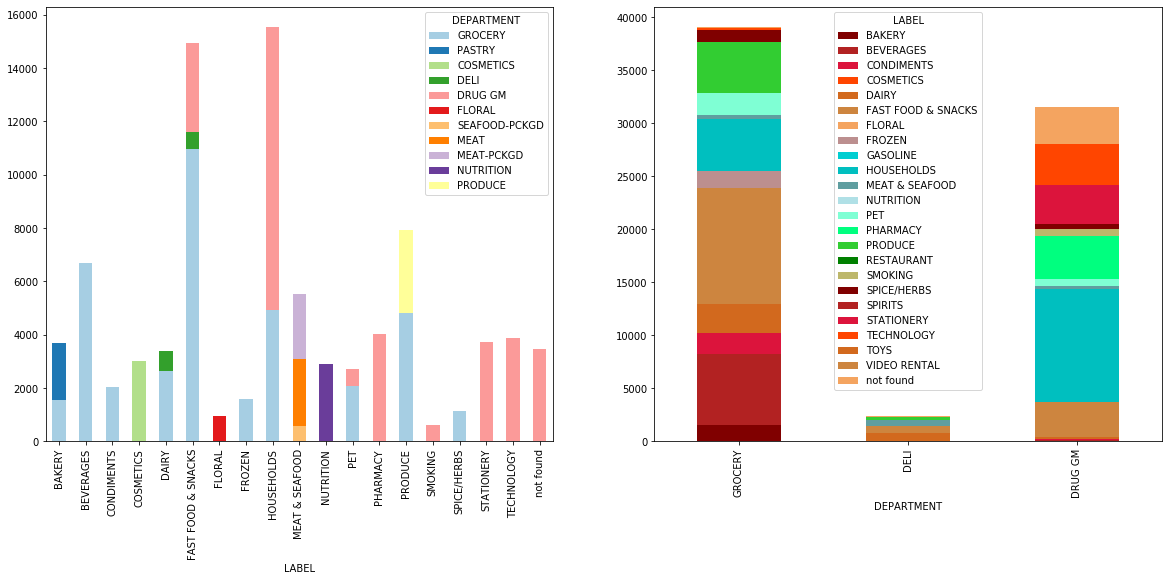

In [36]:
ProductLabels= product.groupby('LABEL').count()
ProductLabels2= product.groupby(by= ['DEPARTMENT','LABEL']).count()
ProductDepartment= product.groupby(by= ['LABEL','DEPARTMENT']).count()
#ProductLabels2 = ProductLabels2.drop(ProductLabels2[ProductLabels2['BRAND'] <=10].index)

#palette : 
my_palette = ["maroon","firebrick","crimson", "orangered","chocolate", "peru","sandybrown","rosybrown","darkturquoise"
        ,"c","cadetblue","powderblue","aquamarine","springgreen","limegreen","green","darkkhaki"]
sns.set_palette(my_palette)


fig = plt.figure(figsize=(20,8))

# Divide the figure into a 2x1 grid, and give  the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 2x1 grid, and give the second section
ax2 = fig.add_subplot(122)

ProductDepartment.BRAND[ProductDepartment['BRAND']>500].unstack().plot.bar(color=sns.color_palette("Paired"),ax= ax1,stacked = True)
ProductLabels2.loc[['DRUG GM','GROCERY','DELI']].BRAND.unstack().plot.bar(color=sns.color_palette(),ax= ax2,stacked = True)


fig.subplots_adjust(hspace=1.3)
fig.subplots_adjust(wspace=0.2)


In the left barplot we observe where we can find the different product types. In x-axis displays the product type and the color label gives the shop (DEPARTMENT) where the product can be found. For example we can see that the households product are mainly found in the drug store (DRUG GM), and most of the meat and seafood products are found in the meat and meat-pckgd shops. 

The right barplot shows the proportions of the different products types, that we can find in the "unspecialized" shops (Deli, the grocery, and the drug store). For example we can see that Deli sales only food products, whereas the drug store proposes an important variety of household products.